In [4]:
import os
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/TrayDataset/'
x_train_dir = os.path.join(DATA_DIR, 'XTrain')
y_train_dir = os.path.join(DATA_DIR, 'yTrain')

x_valid_dir = os.path.join(DATA_DIR, 'XVal')
y_valid_dir = os.path.join(DATA_DIR, 'yVal')

x_test_dir = os.path.join(DATA_DIR, 'XTest')
y_test_dir = os.path.join(DATA_DIR, 'yTest')


path, dirs, files = next(os.walk(x_valid_dir))
file_count = len(files)
print(file_count)

12


In [33]:
import albumentations as albu
import albumentations.augmentations.functional as F

def get_training_augmentation():
    train_transform = [

        albu.Resize(256, 416, p=1),
        albu.RandomCrop(224, 224),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.4),
        albu.OneOf([albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
        albu.CLAHE(p=1),albu.HueSaturationValue(p=1)],p=0.9,),
        albu.IAAAdditiveGaussianNoise(p=0.2),]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(256, 416)]

    return albu.Compose(test_transform)
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),]
    return albu.Compose(_transform)

# helper function for data visualization
def visualizeData(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [37]:
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """TrayDataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        #get images(x) and masks(y) ids
        self.ids_x = sorted(os.listdir(images_dir))
        #['1001a01.jpg', '1005a.jpg', '1006a72.jpg', '2001a72.jpg', '2002a.jpg'] etc.
        self.ids_y = sorted(os.listdir(masks_dir))

        #get images(x) and masks(y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        #'/content/drive/My Drive/Colab Notebooks/TrayDataset/XTest/1001a01.jpg'
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids_x)

In [38]:
CLASSES = ['background','tray','cutlery','form','straw','meatball',
               'beef','roastlamb','beeftomatocasserole','ham','bean','cucumber',
               'leaf','tomato','boiledrice','beefmexicanmeatballs',
               'spinachandpumpkinrisotto','bakedfish','gravy','zucchini','carrot',
               'broccoli','pumpkin','celery','sandwich','sidesalad','tartaresauce',
               'jacketpotato','creamedpotato','bread','margarine',
               'soup','apple','cannedfruit','milk','vanillayogurt',
               'jelly','custard','lemonsponge','juice','applejuice','orangejuice','water']

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


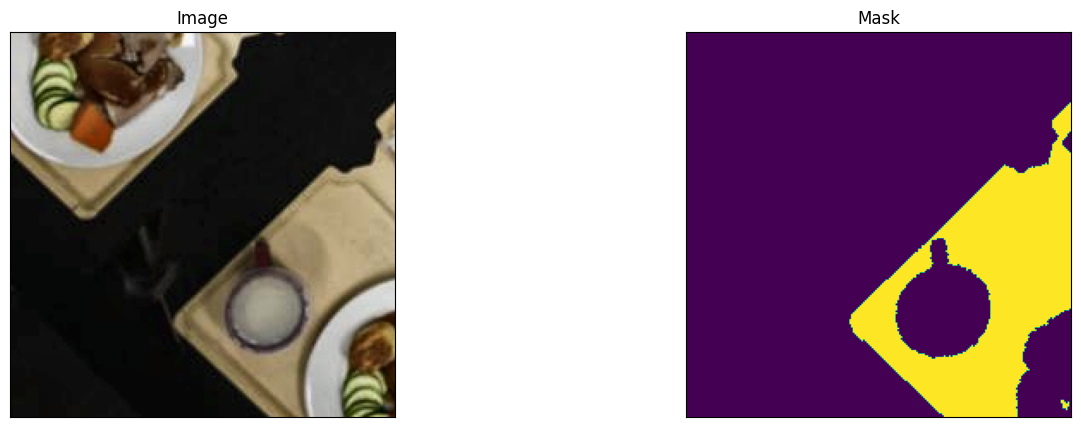

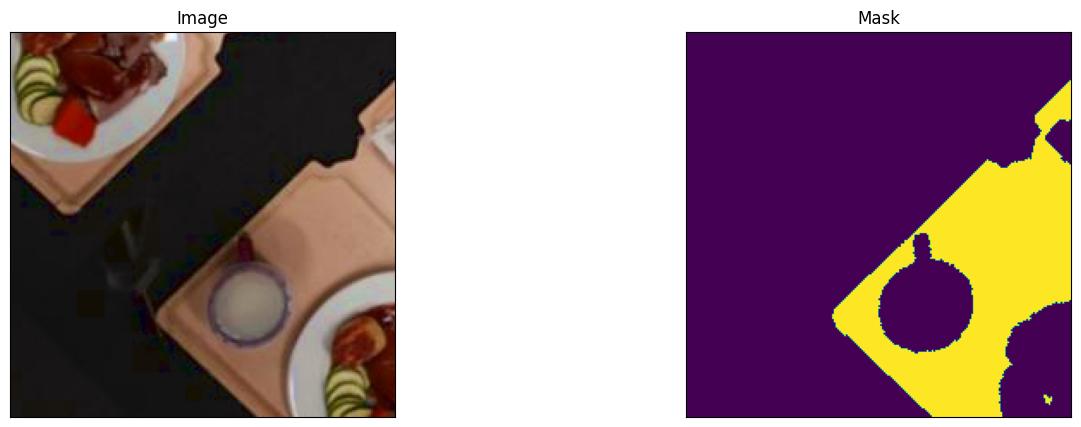

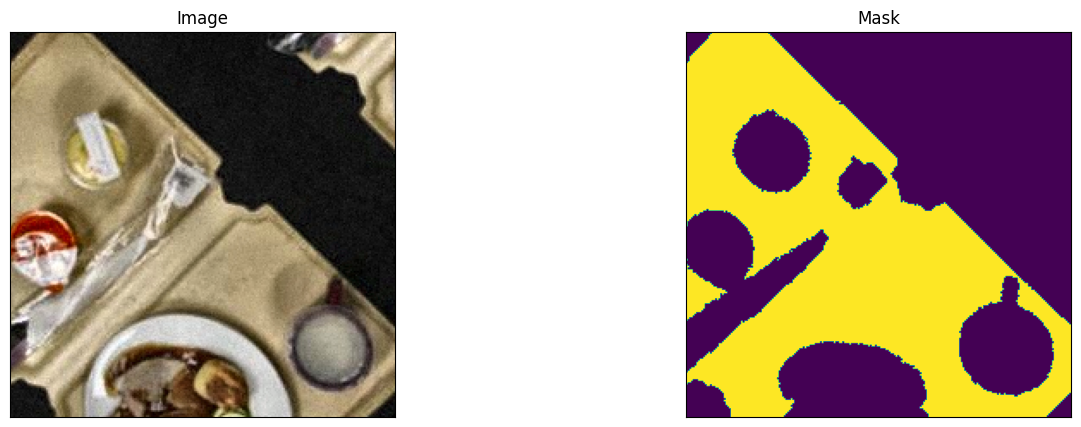

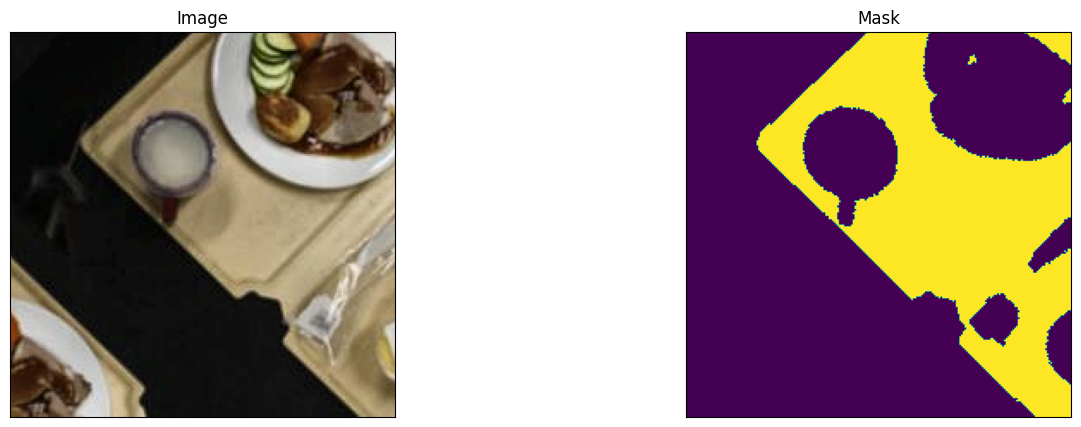

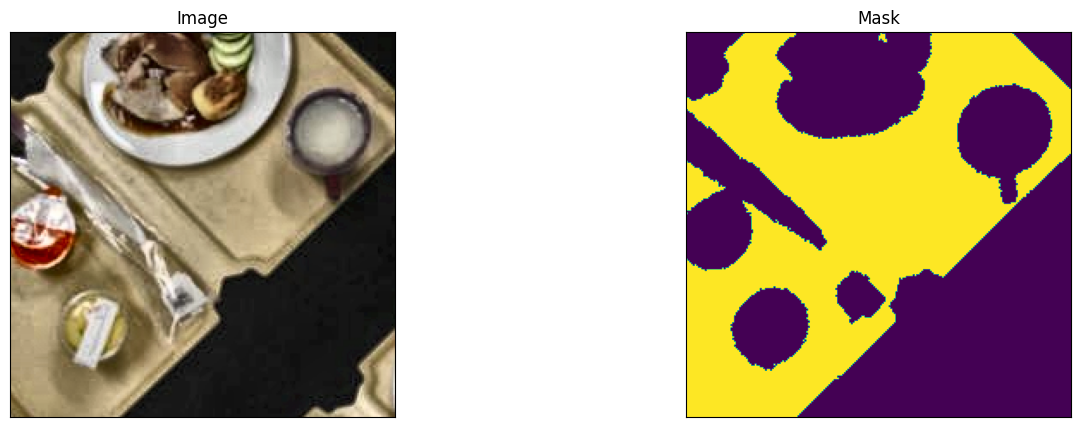

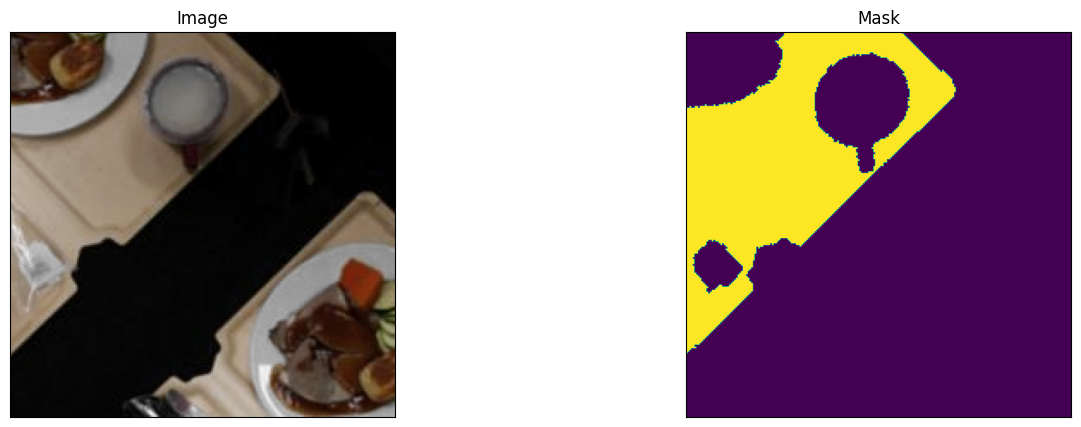

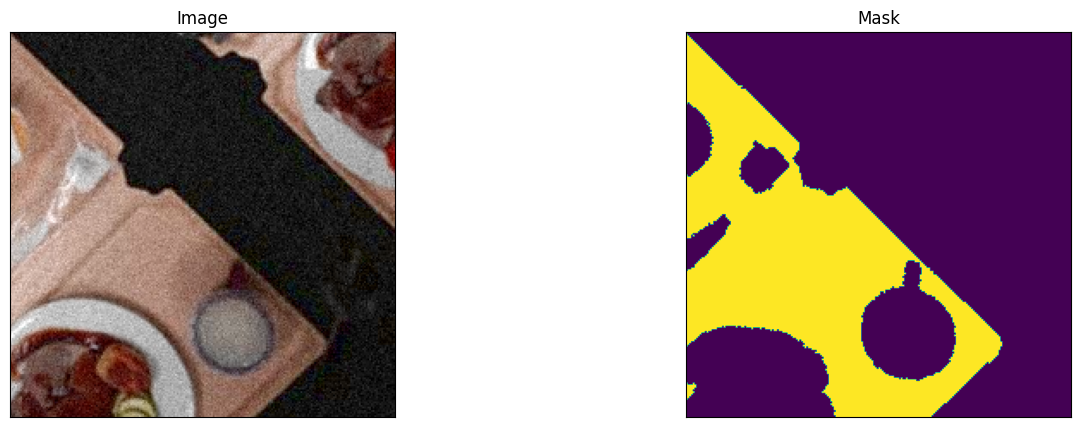

In [39]:
import cv2
import matplotlib.pyplot as plt

augmented_dataset = Dataset( x_train_dir, y_train_dir,
                            augmentation=get_training_augmentation(), classes=['tray'],)

# same image with different  transforms
for i in range(7):
    image, mask = augmented_dataset[8]
    visualizeData(image=image, mask=mask.squeeze(-1))